<a href="https://colab.research.google.com/github/palberth/CienciaDatos-MASDI/blob/main/Laboratorio2_BigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instalación de Librerias**

In [ ]:
!pip install --upgrade google-cloud-bigquery google-auth google-auth-oauthlib google-auth-httplib2 requests pandas

# **Autenticación** **colab**

In [ ]:
from google.colab import auth
auth.authenticate_user()
print("Autenticación exitosa")

Autenticación exitosa


# **Variables de Entorno y Secretos**

In [ ]:
import os, subprocess

PROJECT_ID  = "bigdata-usta-1"
BUCKET_NAME = "bucket-alkasoft"
DATASET_ID  = "crypto_dataset"
TABLE_ID    = "prices_intraday"
REGION      = "us-east1"
COINS       = ["bitcoin", "ethereum", "cardano"]
VS_CURRENCY = "usd"
DAYS        = 30

api_key = subprocess.check_output([
        "gcloud","secrets","versions","access","latest",
        "--secret=coingecko_key", f"--project={PROJECT_ID}"
        ]).decode().strip()
os.environ["COINGECKO_API_KEY"] = api_key
print("🔐 API key cargada desde Secret Manager")

🔐 API key cargada desde Secret Manager


# **Visualizar contenido de la variable SECRET**



In [ ]:
print(api_key)

CG-nVrdyYeXuZZVDjDTLbJijDnS


# **Conectarse, Descargar de COINGECKO y Generar los Archivos RAW y PROCESSED**

In [ ]:
import os, time, requests, pandas as pd
from datetime import datetime

os.makedirs("data/raw", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)

today = datetime.utcnow().strftime("%Y-%m-%d")

def fetch_market_chart(coin, vs_currency="usd", days=30):
    url = f"https://api.coingecko.com/api/v3/coins/{coin}/market_chart"
    params = {"vs_currency": vs_currency, "days": days}
    headers = {}
    r = requests.get(url, params=params, headers=headers, timeout=30)
    # Retrys básicos
    for i in range(3):
        if r.status_code == 200: break
        if r.status_code in (429,500,502,503,504):
            time.sleep(2*(i+1)); r = requests.get(url, params=params, headers=headers, timeout=30)
    r.raise_for_status()
    return r

generated_csvs = []

for coin in COINS:
    r = fetch_market_chart(coin, VS_CURRENCY, DAYS)

    # RAW
    raw_path = f"data/raw/{coin}_prices_{today}.json"
    with open(raw_path, "w") as f:
        f.write(r.text)

    # Procesado
    data = r.json()
    prices = data.get("prices", [])  # [ [ts_ms, price], ... ]
    if not prices:
        print(f"Sin 'prices' para {coin}")
        continue
    df = pd.DataFrame(prices, columns=["timestamp_ms","price"])
    df["timestamp"] = pd.to_datetime(df["timestamp_ms"], unit="ms", utc=True)
    df["date"] = df["timestamp"].dt.date
    df["coin"] = coin
    df["vs_currency"] = VS_CURRENCY
    df = df[["coin","vs_currency","timestamp","date","price"]].sort_values("timestamp")

    csv_path = f"data/processed/{coin}_prices_{today}.csv"
    df.to_csv(csv_path, index=False)
    generated_csvs.append(csv_path)
    print(f"{coin}: {len(df):,} filas → {csv_path}")

generated_csvs[:3]

/tmp/ipython-input-3467654450.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  today = datetime.utcnow().strftime("%Y-%m-%d")


bitcoin: 719 filas → data/processed/bitcoin_prices_2025-09-16.csv
ethereum: 719 filas → data/processed/ethereum_prices_2025-09-16.csv
cardano: 719 filas → data/processed/cardano_prices_2025-09-16.csv


['data/processed/bitcoin_prices_2025-09-16.csv',
 'data/processed/ethereum_prices_2025-09-16.csv',
 'data/processed/cardano_prices_2025-09-16.csv']

# **Subir a GCS**

In [ ]:
!gcloud config set project {PROJECT_ID}

!gsutil -m cp data/raw/*.json gs://{BUCKET_NAME}/S2/raw/
!gsutil -m cp data/processed/*.csv gs://{BUCKET_NAME}/S2/processed/

Updated property [core/project].
Copying file://data/raw/bitcoin_prices_2025-09-16.json [Content-Type=application/json]...
Copying file://data/raw/ethereum_prices_2025-09-16.json [Content-Type=application/json]...
Copying file://data/raw/cardano_prices_2025-09-16.json [Content-Type=application/json]...
/
Operation completed over 3 objects/218.0 KiB.                                    
Copying file://data/processed/bitcoin_prices_2025-09-16.csv [Content-Type=text/csv]...
Copying file://data/processed/cardano_prices_2025-09-16.csv [Content-Type=text/csv]...
Copying file://data/processed/ethereum_prices_2025-09-16.csv [Content-Type=text/csv]...
/
Operation completed over 3 objects/157.8 KiB.                                    


# **(Pruebas) Usando Python**

In [ ]:
from google.cloud import storage

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)

for file in os.listdir("data/processed"):
    blob = bucket.blob(f"S2/processed/copy-{file}")
    blob.upload_from_filename(f"data/processed/{file}")
    print(f"Subido: {file}")

Subido: cardano_prices_2025-09-16.csv
Subido: ethereum_prices_2025-09-16.csv
Subido: bitcoin_prices_2025-09-16.csv


# **Crear Dataset y tabla en BigQuery y cargar Data desde GCS**

In [ ]:
from google.cloud import bigquery

bq = bigquery.Client(project=PROJECT_ID)

dataset_ref = bigquery.Dataset(f"{PROJECT_ID}.{DATASET_ID}")
dataset_ref.location = REGION
try:
    bq.get_dataset(dataset_ref)
    print(f"Dataset existente: {PROJECT_ID}.{DATASET_ID}")
except Exception:
    bq.create_dataset(dataset_ref, exists_ok=True)
    print(f"Dataset creado: {PROJECT_ID}.{DATASET_ID}")


table_id = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"

job_config = bigquery.LoadJobConfig(
    autodetect=True,
    skip_leading_rows=1,
    source_format=bigquery.SourceFormat.CSV,
    write_disposition=bigquery.WriteDisposition.WRITE_APPEND,
)


uris = [f"gs://{BUCKET_NAME}/S2/processed/{os.path.basename(p)}" for p in generated_csvs]
print("Cargando URIs:", uris[:3], "…")

load_job = bq.load_table_from_uri(uris, table_id, job_config=job_config)
load_job.result()

table = bq.get_table(table_id)
print(f"Tabla lista: {table_id} → {table.num_rows:,} filas")

Dataset creado: bigdata-usta-1.crypto_dataset
Cargando URIs: ['gs://bucket-alkasoft/S2/processed/bitcoin_prices_2025-09-16.csv', 'gs://bucket-alkasoft/S2/processed/ethereum_prices_2025-09-16.csv', 'gs://bucket-alkasoft/S2/processed/cardano_prices_2025-09-16.csv'] …
Tabla lista: bigdata-usta-1.crypto_dataset.prices_intraday → 2,157 filas


# **Query Simple**

In [ ]:
query_change = f"""
SELECT
    coin,
    date,
    AVG(price) AS avg_price
  FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
  GROUP BY coin, date
  order by coin, date
"""
df_change = bq.query(query_change).to_dataframe()
df_change.head()

,coin,date,avg_price
0,bitcoin,2025-08-17,118042.878844
1,bitcoin,2025-08-18,115939.564255
2,bitcoin,2025-08-19,114708.777081
3,bitcoin,2025-08-20,113685.017487
4,bitcoin,2025-08-21,113320.049738


In [ ]:
df.shape

(719, 5)

# **Grafica del comportamiento de las Monedas**

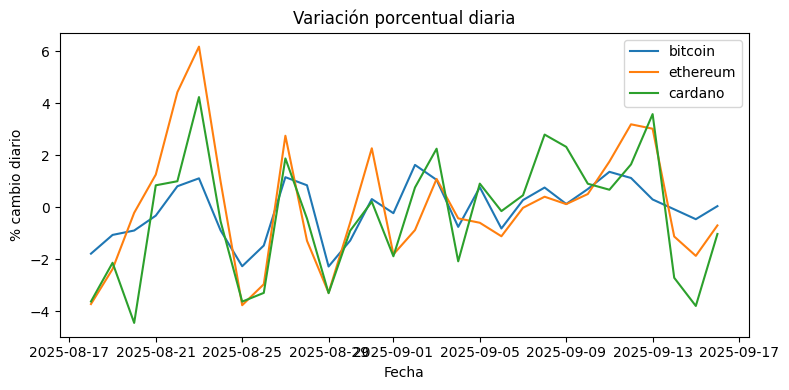

In [ ]:
import matplotlib.pyplot as plt

query_change = f"""
WITH daily AS (
  SELECT
    coin,
    date,
    AVG(price) AS avg_price
  FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
  GROUP BY coin, date
)
SELECT
  coin,
  date,
  avg_price,
  100.0 * (avg_price - LAG(avg_price) OVER(PARTITION BY coin ORDER BY date))
        / LAG(avg_price) OVER(PARTITION BY coin ORDER BY date) AS pct_change
FROM daily
ORDER BY coin, date
"""
df_change = bq.query(query_change).to_dataframe()
df_change.head()

# Top 2 monedas por variación absoluta entre días
subset = df_change.dropna().copy()
subset["abs_change"] = subset["pct_change"].abs()
top = subset.sort_values("abs_change", ascending=False).groupby("coin").head(1)

plt.figure(figsize=(8,4))
for coin in COINS:
    s = subset[subset["coin"] == coin]
    plt.plot(s["date"], s["pct_change"], label=coin)
plt.title("Variación porcentual diaria")
plt.xlabel("Fecha"); plt.ylabel("% cambio diario")
plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv("data/processed/bitcoin_prices_2025-09-16.csv")

parquet_path = "data/processed/bitcoin_prices_2025-09-16.parquet"

df.to_parquet(parquet_path, engine="pyarrow", index=False)

print(f"Archivo guardado en Parquet: {parquet_path}")

Archivo guardado en Parquet: data/processed/bitcoin_prices_2025-09-16.parquet


In [ ]:
import os

csv_size = os.path.getsize("data/processed/bitcoin_prices_2025-09-16.csv")/1024
pq_size  = os.path.getsize("data/processed/bitcoin_prices_2025-09-16.parquet")/1024

print(f"Tamaño CSV: {csv_size:.2f} KB")
print(f"Tamaño Parquet: {pq_size:.2f} KB")

Tamaño CSV: 52.57 KB
Tamaño Parquet: 18.98 KB
